In [1]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 401
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("R",zenith=np.array([9,9,9])*ceo.constants.ARCMIN2RAD,
                    azimuth=np.array([0,120,240])*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
GMT = ceo.GMT_MX(D,nPx)
wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

In [3]:
GMT.M1.motion_CS.origin[0,2] = -10e-6
GMT.M1.motion_CS.origin[3,2] = -10e-6
GMT.M1.motion_CS.origin[1,2] = 5e-6
GMT.M1.motion_CS.origin[5,2] = -5e-6
GMT.M1.motion_CS.origin[4,2] = 5e-6
GMT.M1.motion_CS.origin[2,2] = -5e-6
GMT.M1.motion_CS.origin[6,2] = 10e-6
GMT.M1.motion_CS.update()
GMT.propagate(src)

In [4]:
src.zenith

array([ 0.00261799,  0.00261799,  0.00261799], dtype=float32)

In [5]:
sps = ceo.SegmentPistonSensor(GMT.M1,src)

@(CEO)>Complex_amplitude: I am empty:(!


In [6]:
print nPx*nPx*2
print src.amplitude.host().shape
print sps.M.f.host().shape

323208
(1206, 402)
(484812, 1)


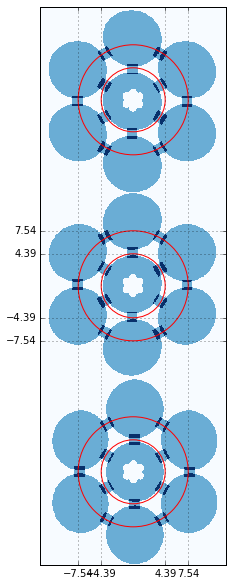

In [7]:
rc = 4.387
rp = 7.543
R = D/2
fig, ax1 = subplots()
fig.set_size_inches((10,10))
#ax1.imshow(src.amplitude.host(),extent=[-R,R,-R,R],interpolation='None',origin='lower')
ax1.imshow(src.amplitude.host()+sps.M.f.host(shape=(src.N_SRC*nPx,nPx)),extent=[-R,R,-R*src.N_SRC,src.N_SRC*R],interpolation='None',cmap='Blues',origin='lower')
ax1.grid()
ax1.set_xticks([-rp,-rc,rc,rp])
ax1.set_yticks([-rp,-rc,rc,rp])
for k in range(src.N_SRC):
    c1 = Circle((0,(k-1)*D),radius=rc, color='r', fill=False)
    ax1.add_patch(c1)
    c2 = Circle((0,(k-1)*D),radius=rp, color='r', fill=False)
    ax1.add_patch(c2)

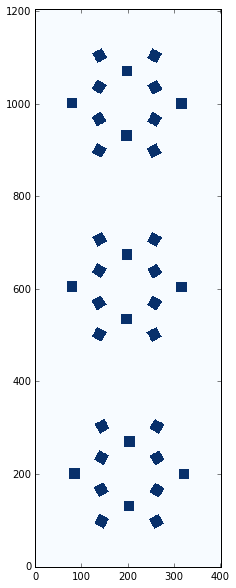

In [8]:
fig, ax1 = subplots()
fig.set_size_inches((10,10))
h = ax1.imshow(sps.M.f.host(shape=(src.N_SRC*nPx,nPx)),interpolation='None',cmap='Blues',origin='lower')
#colorbar(h)

In [10]:
print sps.W.phase.shape
print 36*48**2

(1, 82944)
82944


In [11]:
sps.propagate(src)
#sps.W.phase.shape

In [12]:
print (25*48)**2

1440000


<matplotlib.colorbar.Colorbar instance at 0x2aafe86d0c20>

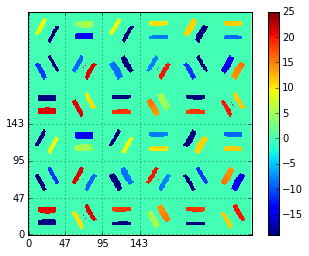

In [13]:
fig, ax1 = subplots()
h = ax1.imshow(sps.W.phase.host(shape=(24*2*6,24*2*6))*1e6,interpolation='None',origin='lower',vmin=-19,vmax=25)
ax1.set_xticks([0, 47, 95, 143])
ax1.set_yticks([0, 47, 95, 143])
ax1.grid()
colorbar(h)

<matplotlib.colorbar.Colorbar instance at 0x2aafe87ffd40>

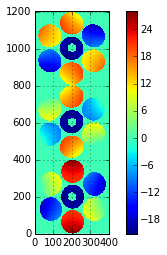

In [14]:
imshow(src.phase.host(units='micron'),interpolation='None',origin='lower')
grid()
colorbar()

In [ ]:
82.5*src.zenith

In [ ]:
np.ceil(np.sqrt(12))